<h1 align=middle> Data Science Challenge </h1>
<h3 align=middle> by Benjamin Chissico </h3>

In [88]:
import pandas as pd 
import numpy as np 

import pathlib 
import matplotlib.pyplot as plt 
import seaborn as sns 
import json 

In [89]:
# load data in 

file_path = pathlib.Path().cwd() / "data"/"data.csv"
claim_path = pathlib.Path().cwd() /"data"/"claim_amounts.csv"
df = pd.read_csv(file_path) # holds the metadata of the vehicle and the driver
df_amount = pd.read_csv(claim_path) # holds the claim amounts of the driver 

In [90]:
df = pd.merge(df,df_amount,how="left",on="IDpol")

### Start of the EDA 

In [91]:
print("Lets start with the head of the dataframe to see what we are working with.")
df.head()

Lets start with the head of the dataframe to see what we are working with.


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,NaN
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82,NaN
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22,NaN
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72,NaN
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72,NaN


In [92]:
# check data types 


data_types = df.dtypes.reset_index().rename(columns={0:"dataType",'index':'columnName'})
data_types

# check the quality based on nan values 
columns = df.columns.tolist()


Lets check if we can recast some of the "object" fields to a category
We assume that every object field that has less than three different values should be a category

### Important disclaimer!

We want to classify a driver's potential to get a claim instead of predicting the amount of the claim.
Therefore, we change create a new column based on the ClaimAmount column, the Column will be called "Y" because it will be our target columns and will either be 0 for no claim or 1 for a claim.

In [93]:
mask = df['ClaimAmount'].isnull()
df.loc[mask,'Y'] = 0
df.loc[~mask,'Y'] = 1

Lets have a quick overview of the distribution of claims vs. no claims 

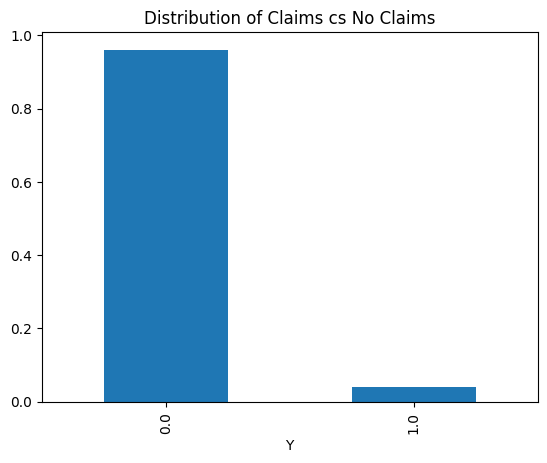

In [94]:
df['Y'].value_counts(normalize=True).plot(kind="bar",title="Distribution of Claims cs No Claims")
plt.show()

We have a lot more no claims than we have drivers that had a claim, lets find out what makes a driver "claim"

In [97]:
data_types

,columnName,dataType
0,IDpol,float64
1,ClaimNb,int64
2,Exposure,float64
3,Area,object
4,VehPower,int64
5,VehAge,int64
6,DrivAge,int64
7,BonusMalus,int64
8,VehBrand,object
9,VehGas,object


In [96]:
cat_mask = data_types['dataType'] == "object"
cat_candidates = data_types.loc[cat_mask].copy()
cat_candidates['columnName']

cats = []
for column in cat_candidates['columnName'].values:
    print(f"Checking Column: {column}")
    values = df.loc[:,column].unique()
    print(f"\tDistinct # of values: {len(values):,}")
    if len(values) <=3:
        cats.append(column)
    
if not cats:
    print("No values found that could be transformed to a category based on our metric"
         )
else:
    print(f"Found these columns that will be transformed to a category: {', '.join(cats)}")
    for cat in cats:
        df[cat] = df[cat].astype('category')

Checking Column: Area
	Distinct # of values: 6
Checking Column: VehBrand
	Distinct # of values: 11
Checking Column: VehGas
	Distinct # of values: 2
Checking Column: Region
	Distinct # of values: 22
Found these columns that will be transformed to a category: VehGas


In [99]:
nan_values = (
    (df
        .isnull()
        .sum() 
        / 
        len(df))
        .reset_index()
        .rename(columns={"index":"columnName",0:"proportionOfNaNValues"})
        .sort_values(by=["proportionOfNaNValues"],ascending=False)

)
nan_values



,columnName,proportionOfNaNValues
12,ClaimAmount,0.961084
0,IDpol,0.000000
1,ClaimNb,0.000000
2,Exposure,0.000000
3,Area,0.000000
4,VehPower,0.000000
5,VehAge,0.000000
6,DrivAge,0.000000
7,BonusMalus,0.000000
8,VehBrand,0.000000


*Nice*, looks like we dont have any NAN Values in the DataSet ;) (in the metadata columns, the claim amounts if not always filled) 

Lets have a general look into the data to see what it represents

In [100]:
# Helper Function 
def analyse_column(series:pd.Series)->None:
    """Helper Function that allows to analyse a specific column"""
    print(f"Analysing of {series.name!r}")

    distinct_values = series.unique()
    print(f"Count of values: {len(distinct_values)}")
    if len(distinct_values) <= 20:
        
        distinct_dct = {'Column':series.name,'data':distinct_values.tolist()}

        print(json.dumps(distinct_dct,indent=2))
    print("\n\n")
    #print(f"Distinct values in the column: {', '.join(distinct_values)}")

In [101]:
_ = df.apply(analyse_column)

Analysing of 'IDpol'
Count of values: 678013



Analysing of 'ClaimNb'
Count of values: 11
{
  "Column": "ClaimNb",
  "data": [
    1,
    2,
    4,
    3,
    11,
    0,
    5,
    6,
    8,
    16,
    9
  ]
}



Analysing of 'Exposure'
Count of values: 187



Analysing of 'Area'
Count of values: 6
{
  "Column": "Area",
  "data": [
    "D",
    "B",
    "E",
    "C",
    "F",
    "A"
  ]
}



Analysing of 'VehPower'
Count of values: 12
{
  "Column": "VehPower",
  "data": [
    5,
    6,
    7,
    4,
    9,
    15,
    8,
    10,
    12,
    11,
    14,
    13
  ]
}



Analysing of 'VehAge'
Count of values: 78



Analysing of 'DrivAge'
Count of values: 83



Analysing of 'BonusMalus'
Count of values: 115



Analysing of 'VehBrand'
Count of values: 11
{
  "Column": "VehBrand",
  "data": [
    "B12",
    "B6",
    "B3",
    "B2",
    "B5",
    "B10",
    "B14",
    "B13",
    "B4",
    "B1",
    "B11"
  ]
}



Analysing of 'VehGas'
Count of values: 2
{
  "Column": "VehGas",
  "data": [

## Let the plotting begin!

<Axes: >

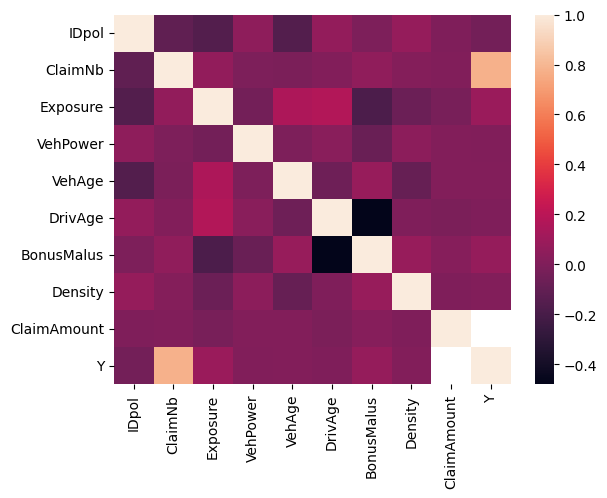

In [102]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr)

In [103]:
# lets have a look at the data that has a higher than .5  or less than -.5 percent correlation
def colorize_cell(cell:float|int):
    pass 
corr.style.applymap(lambda cell : 'color:green' if cell >.4 else 'color:blue' if cell <-.4 else '')

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,Y
IDpol,1.000000,-0.110348,-0.160259,0.048615,-0.156947,0.063685,-0.005848,0.070689,-0.003868,-0.041886
ClaimNb,-0.110348,1.000000,0.063343,-0.007582,-0.016817,0.010298,0.052456,0.011675,0.005014,0.779022
Exposure,-0.160259,0.063343,1.000000,-0.045006,0.151258,0.171744,-0.181478,-0.070793,-0.026879,0.089857
VehPower,0.048615,-0.007582,-0.045006,1.000000,-0.006170,0.030077,-0.075776,0.043043,0.006213,0.000974
VehAge,-0.156947,-0.016817,0.151258,-0.006170,1.000000,-0.059278,0.079943,-0.090419,0.008298,0.011057
DrivAge,0.063685,0.010298,0.171744,0.030077,-0.059278,1.000000,-0.479625,-0.004604,-0.015929,-0.005352
BonusMalus,-0.005848,0.052456,-0.181478,-0.075776,0.079943,-0.479625,1.000000,0.077753,0.018339,0.069954
Density,0.070689,0.011675,-0.070793,0.043043,-0.090419,-0.004604,0.077753,1.000000,-0.004403,0.011240
ClaimAmount,-0.003868,0.005014,-0.026879,0.006213,0.008298,-0.015929,0.018339,-0.004403,1.000000,nan
Y,-0.041886,0.779022,0.089857,0.000974,0.011057,-0.005352,0.069954,0.011240,nan,1.000000


Hmm looks like we dont have a lot of correlation going on. 
We found a negative correlation between the driver's age and the BonusMalus level. 
This makes sense, because in most cases, young drivers have a higher BonusMalus then older drivers

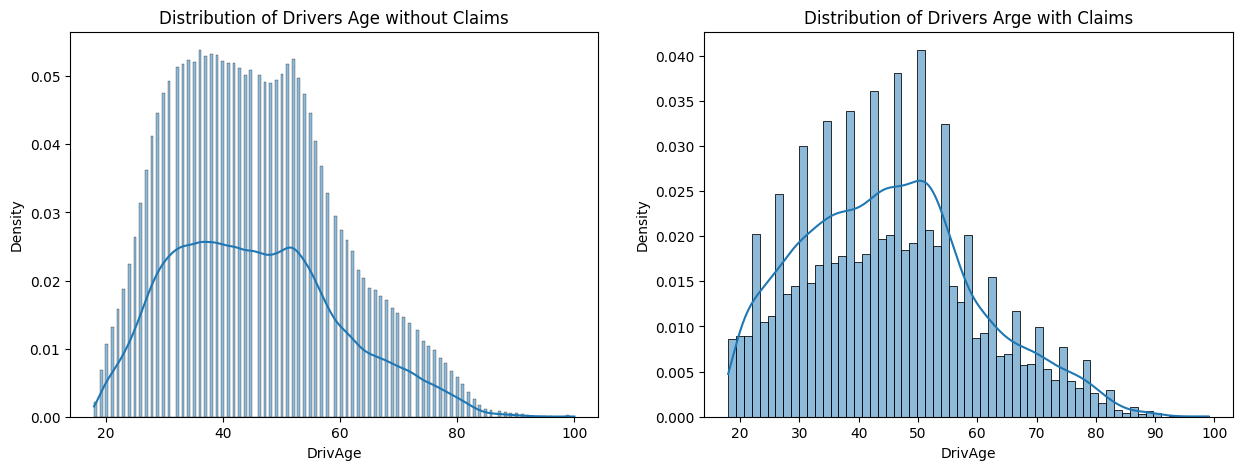

In [104]:
## Plot Age distribution from claims drivers vs non claims driver
mask = df.Y == 0 
f,axes = plt.subplots(1,2,figsize=(15,5))
sns.histplot(data=df.loc[mask],x='DrivAge',ax=axes[0],kde=True,stat="density")
sns.histplot(data=df.loc[~mask],x='DrivAge',ax=axes[1],kde=True,stat="density")
axes[0].set_title("Distribution of Drivers Age without Claims")
axes[1].set_title("Distribution of Drivers Arge with Claims")
plt.show()



<h6 align=middle>The histplot analysis of driving ages reveals a leftward skew, indicating a higher concentration of younger drivers</h6>

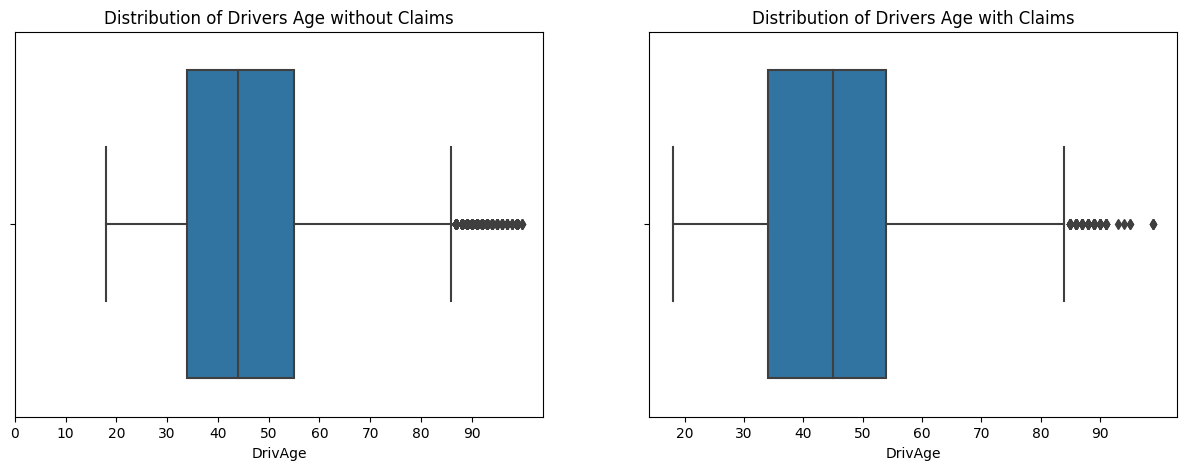

In [105]:
# looking at the outliers of the drivers age ranges 
mask = df.Y == 0 
f,axes = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df.loc[mask],x='DrivAge',ax=axes[0])
axes[0].set_xticks(range(0,100,10))
axes[1].set_xticks(range(0,100,10))

sns.boxplot(data=df.loc[~mask],x='DrivAge',ax=axes[1])
axes[0].set_title("Distribution of Drivers Age without Claims")
axes[1].set_title("Distribution of Drivers Age with Claims")
plt.show()



## BonusMalus

lets do the same exercise for the Bonus Malus

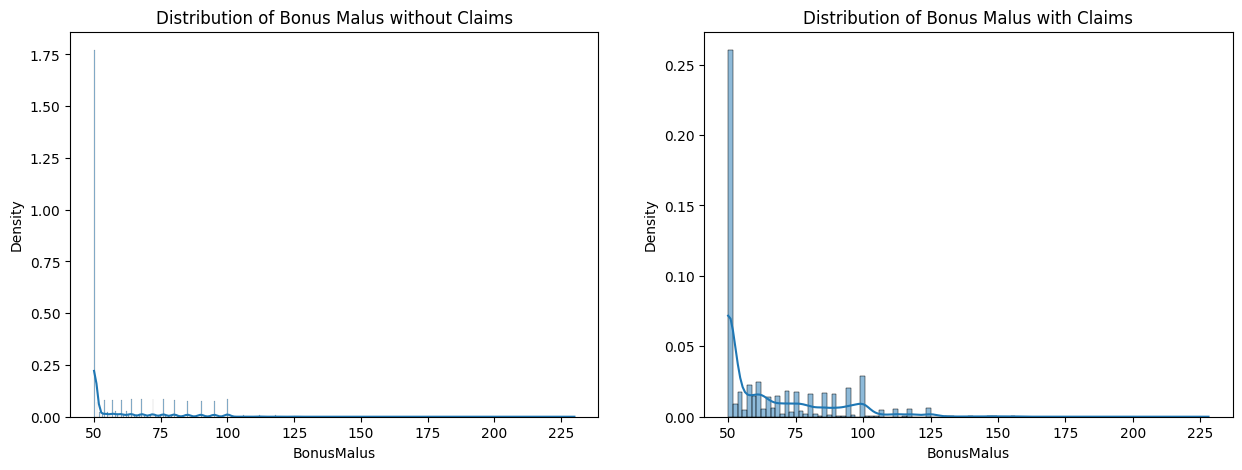

In [106]:
mask = df.Y == 0 
f,axes = plt.subplots(1,2,figsize=(15,5))
sns.histplot(data=df.loc[mask],x='BonusMalus',ax=axes[0],kde=True,stat="density")
sns.histplot(data=df.loc[~mask],x='BonusMalus',ax=axes[1],kde=True,stat="density")
axes[0].set_title("Distribution of Bonus Malus without Claims")
axes[1].set_title("Distribution of Bonus Malus with Claims")
plt.show()

okay, not really helpful. We figured that the Bonus Malus

In [107]:
Y_COLS = ['ClaimAmount','Y','IDpol','ClaimNb']
columns_to_check = [col for col in df.columns.tolist() if col not in Y_COLS]

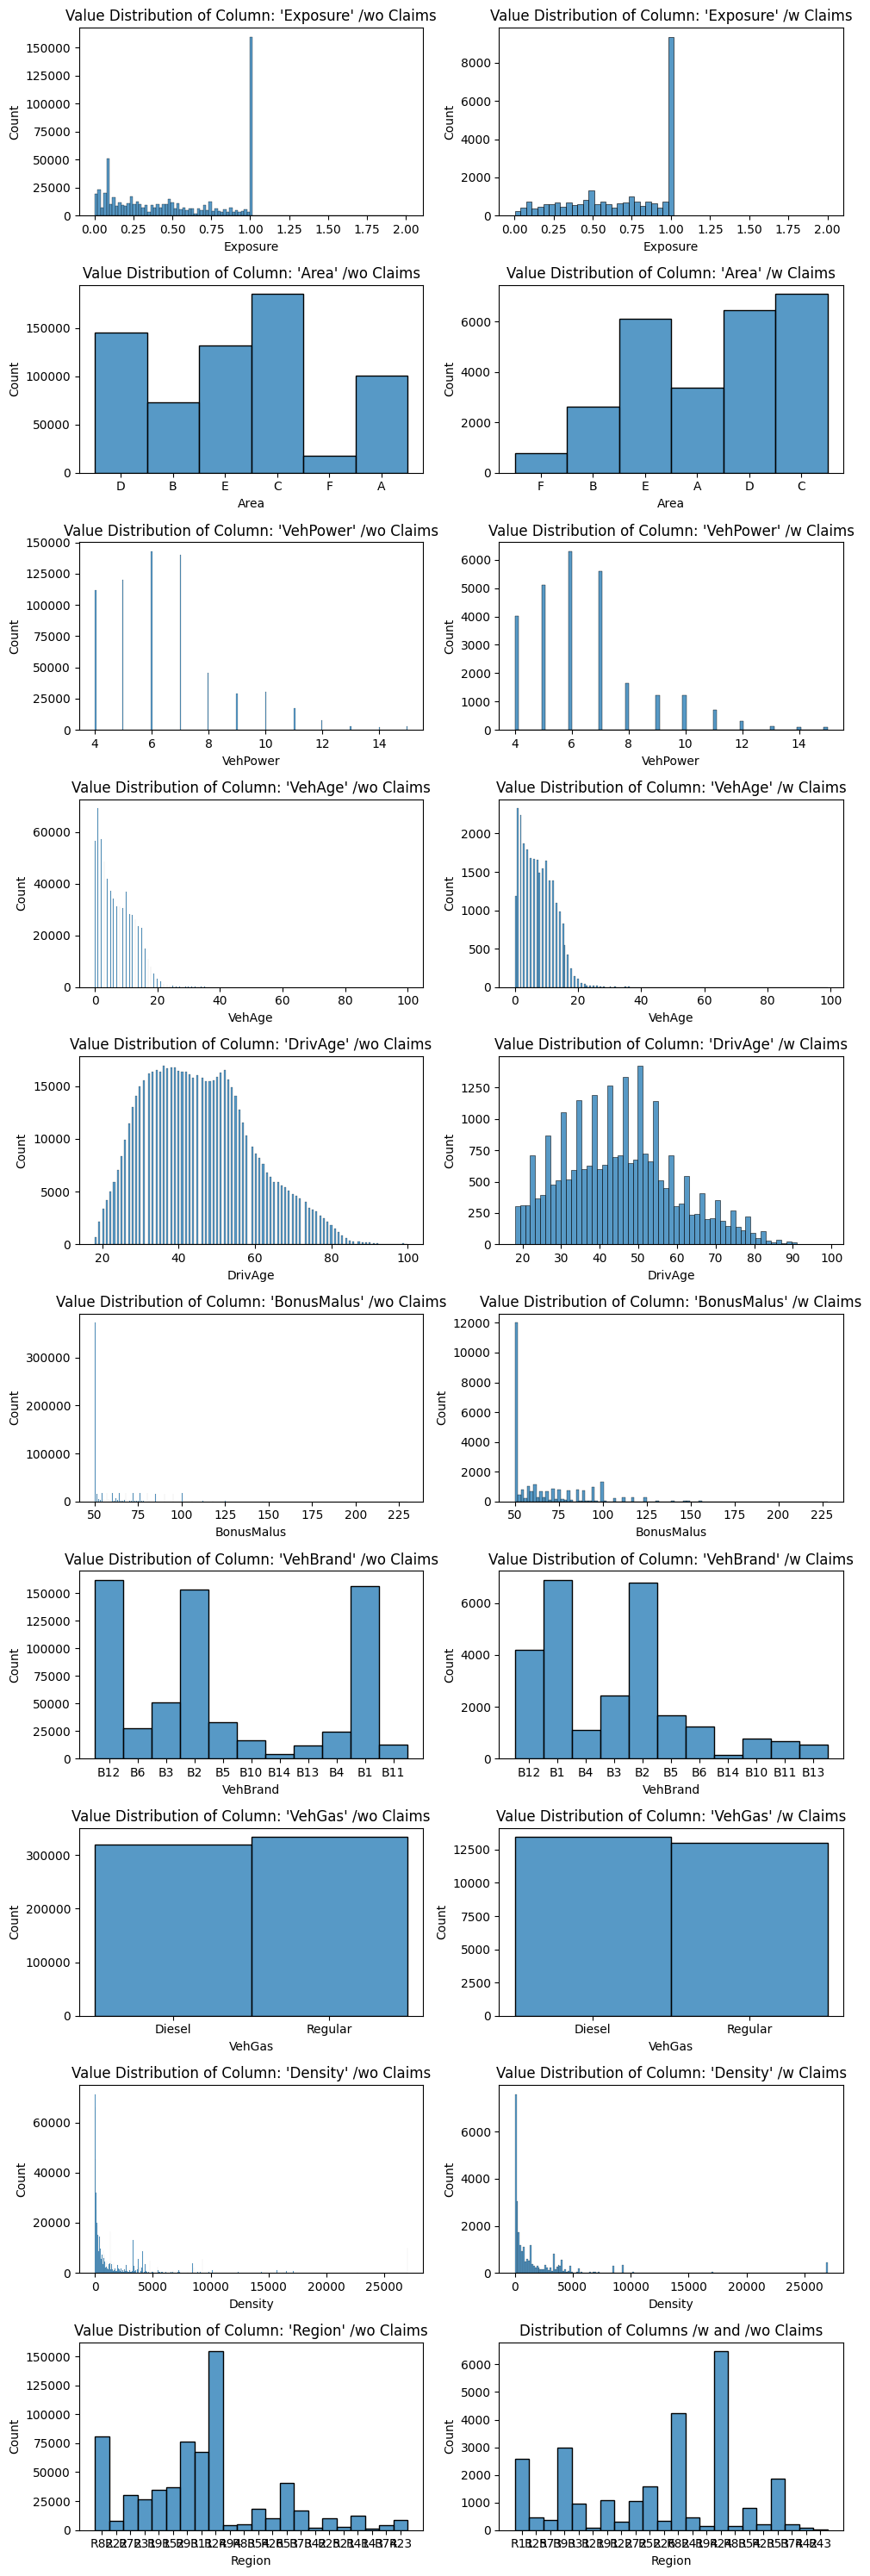

In [108]:
f , axes = plt.subplots(len(columns_to_check),2,figsize=(10,30))
for idx,column in enumerate(columns_to_check):
    sns.histplot(data=df.loc[mask],x=column,ax=axes[idx][0])
    sns.histplot(data=df.loc[~mask],x=column,ax=axes[idx][1])
    axes[idx][0].set_title(f"Value Distribution of Column: {column!r} /wo Claims")
    axes[idx][1].set_title(f"Value Distribution of Column: {column!r} /w Claims")
    
    

    
plt.tight_layout()
plt.title("Distribution of Columns /w and /wo Claims")
plt.show()

All rendered graphes don't look particular suspicious. 

## Next Steps 

Preparation of feature engineering

In [110]:
save_path = pathlib.Path().cwd() / "output"/"pre-processed"
if not save_path.exists():
    save_path.mkdir(parents=True)
df.to_pickle(save_path/"eda-data.pkl")